In [36]:

!pip install keras_tuner --upgrade

In [25]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras
import keras_tuner as kt

#models
from tensorflow.keras.applications import  EfficientNetB1, MobileNetV3Large, ConvNeXtBase, EfficientNetB3 #Xception

#preproces
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:

SIZE = 240 
bs = 16

### Visualisation

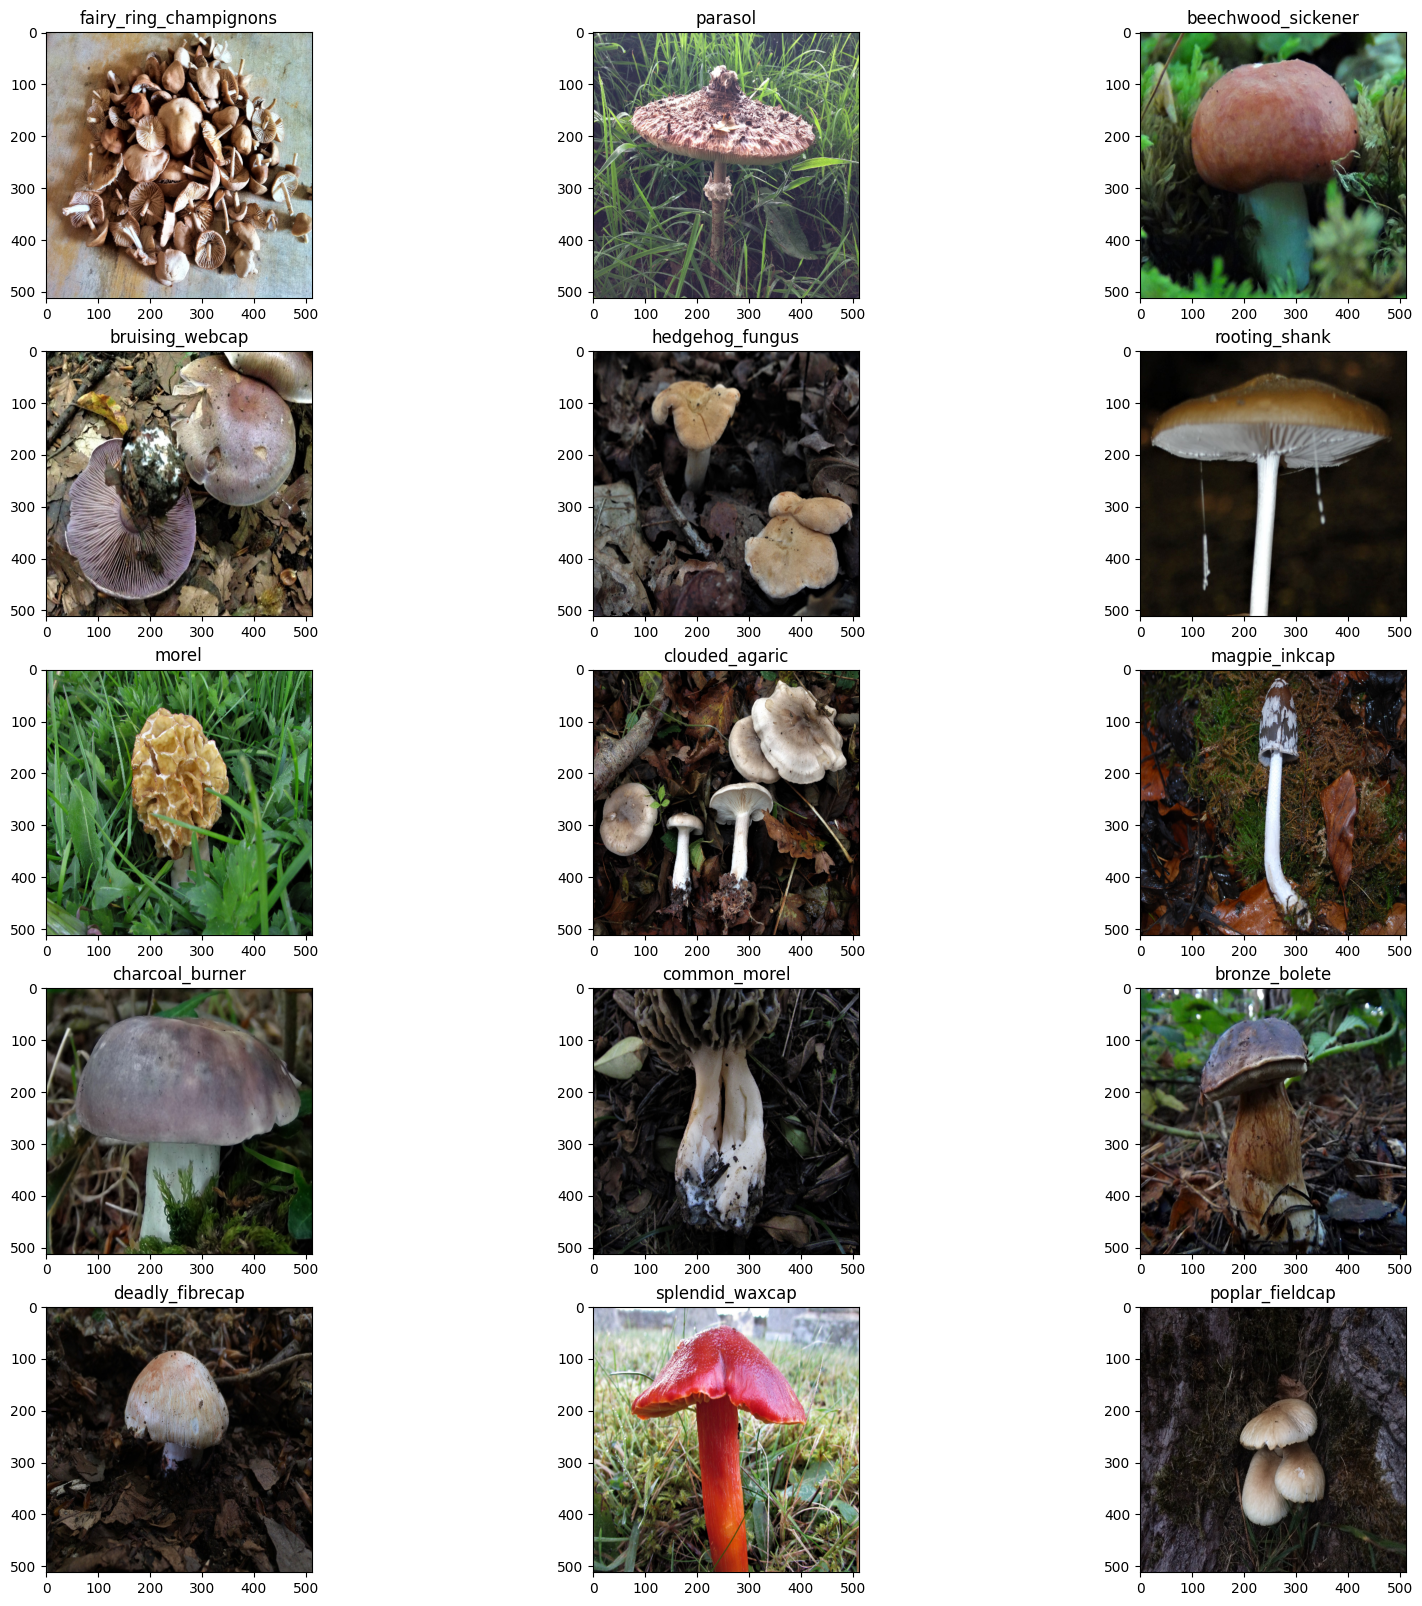

In [5]:

imgs = glob(r'/kaggle/input/mushrooms-classification/train/*/*')
fig , ax = plt.subplots(5, 3, figsize=(20, 20))
fig.subplots_adjust()
im_list = np.random.choice(imgs, 15)
for axi, im in zip( ax.flat, im_list):
    axi.set_title(im.split('/')[5],)
    axi.imshow(plt.imread(im), )

## Labels distribution

In [6]:

labels = [el.split('/')[5] for el in imgs ]
distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 

In [7]:
counter_dict = {k:v for k,v in Counter(labels).items()} 


In [8]:
df = pd.DataFrame(counter_dict.items(),columns =['name', 'count'] )
df.describe()


,count
count,214.000000
mean,11.654206
std,1.126737
min,6.000000
25%,12.000000
50%,12.000000
75%,12.000000
max,13.000000


In [10]:
unq = []
[unq.append(el) for el in distribution_dict.values() if el not in unq];
unq

[0.48, 0.4, 0.44, 0.36, 0.24, 0.32, 0.28, 0.52]

In [31]:

labels = [el.split('/')[5] for el in imgs ]
distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 

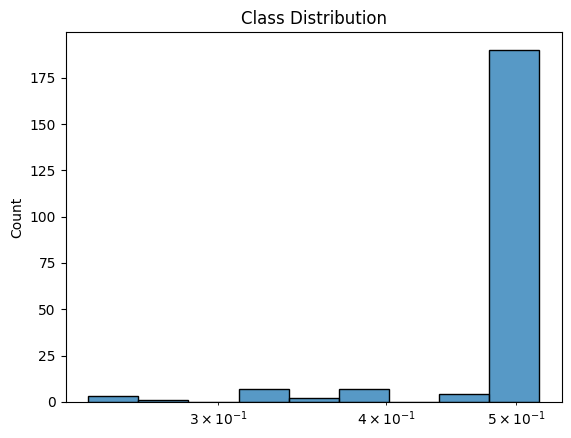

In [32]:
plt.title('Class Distribution')

sns.histplot(x=distribution_dict.values(),log_scale=True);

## Low frequency class

In [33]:

for k, v in distribution_dict.items():
        if v in [el for el in unq if el < 0.3]:
            print(k)

orange_birch_bolete
deadly_webcap
devils_bolete
cinnamon_bracket


## Take 25 % for tuning
We take first 54 classes becouse we have not enough images

In [9]:
X_train =  glob(r'/kaggle/input/mushrooms-classification/train/*/*')

len(X_train)

2494

In [10]:
# take first 1/4 from sorted dataset
X_train = X_train[:int(np.round(len(X_train)/4))]
len(X_train)

624

In [11]:


X_test =  sorted(glob(r'/kaggle/input/mushrooms-classification/test/*/*'))
y_test  = [el.split('/')[5] for el in X_test ]
y_train = [el.split('/')[5] for el in X_train]
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])


In [12]:
test = test[test['y'].isin(train['y'])] #test data must have the same classes 

## Data generation

In [13]:

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)
valid_gen = ImageDataGenerator(rescale=1./255)

In [14]:

tarin_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE))

Found 624 validated image filenames belonging to 54 classes.
Found 158 validated image filenames belonging to 54 classes.


## Tuning

## TUNER MODEL TUNER

In [63]:
cls_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)


In [62]:



def build_model(hp, num_classes=54, shape=(SIZE,SIZE,3), alpha = cls_weight):
    inputs = tf.keras.layers.Input(shape=shape)
    

    efb3 = EfficientNetB3(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None)
    
    
    efb1 = EfficientNetB1(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)
    
    mnv3 = MobileNetV3Large(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)

    #convnb = ConvNeXtBase(include_top=False,
        #weights='imagenet',
        #input_tensor=inputs, # !
        #input_shape=None,
        #pooling=None,)


    # EfficientNetB1, EfficientNetB5, Xception, MobileNetV3Large, ConvNeXtBase
    
    
    hp_model = hp.Choice('model', values=['efb3', 'efb1','mnv3'])
    
    if hp_model == 'efb3':
        model = efb3  
    elif hp_model == 'mnv3':
        model = mnv3
    elif hp_model == 'efb1':
        model = efb1  
    else:
        raise
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    
    dropout_rate = 0.6
    x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs)
    
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=alpha,
        gamma=1.5,
        from_logits=False)
    
    learning_rate = 1e-3 #2
    
 
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [64]:

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3, seed=123, overwrite = True)

In [65]:

tuner.search(tarin_gen, epochs=7, validation_data=test_gen, batch_size=bs)
#

Trial 3 Complete [00h 05m 25s]
val_loss: 3.9134726524353027

Best val_loss So Far: 3.9134726524353027
Total elapsed time: 00h 14m 35s


In [66]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
model: efb1
Score: 3.9134726524353027

Trial 0 summary
Hyperparameters:
model: efb3
Score: 3.9207215309143066

Trial 1 summary
Hyperparameters:
model: mnv3
Score: 4.113779544830322


In [67]:

best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'model': 'efb1'}

## Optimize params

In [50]:
cls_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

#inv_cls_weight = [1/el for el in cls_weight]

In [57]:
 def build_model(hp, num_classes=54, shape=(SIZE,SIZE,3), alpha=cls_weight):
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB1(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        #classes=num_classes,
        classifier_activation='softmax')
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    
    hp_top_dropout_rate = hp.Choice('top_dropout_rate', values=[0.3, 0.5, 0.7])
    x = tf.keras.layers.Dropout( hp_top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    hp_gamma = hp.Choice('gamma', values=[2, 4, 6])
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=alpha,
        gamma=hp_gamma,
        from_logits=False)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'rmsprop','nadam'])
    if hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=hp_learning_rate)
    else:
        raise
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [58]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3, seed=123, overwrite = True)

In [59]:
tuner.search(tarin_gen, epochs=7, validation_data=test_gen, batch_size=bs)

Trial 3 Complete [00h 05m 04s]
val_loss: 3.78847599029541

Best val_loss So Far: 3.595337390899658
Total elapsed time: 00h 15m 19s


In [60]:

best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'top_dropout_rate': 0.3,
 'gamma': 6,
 'learning_rate': 0.0001,
 'optimizer': 'rmsprop'}

In [61]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
top_dropout_rate: 0.3
gamma: 6
learning_rate: 0.0001
optimizer: rmsprop
Score: 3.595337390899658

Trial 1 summary
Hyperparameters:
top_dropout_rate: 0.3
gamma: 6
learning_rate: 0.001
optimizer: rmsprop
Score: 3.6643407344818115

Trial 2 summary
Hyperparameters:
top_dropout_rate: 0.3
gamma: 4
learning_rate: 0.001
optimizer: rmsprop
Score: 3.78847599029541


## Conclusions
We still have a problem concerning with the size of dataset.  
2K images for 215 clases is too small. Even so I use datagenerator it is not enough imagese for proper training.  
One of the option it is use a lot of epoch for training with datageneration, the other is increas the numbers of images and expand the current dataset.